$$ ITI \space AI-Pro: \space Intake \space 45 $$
$$ Deep \space Learning $$
$$ Segmentation \space and \space classification \space of \space Dogs \space and \space Cats $$

# `01` Assignment 01
- Design your own U-Net to segment the lung fields from chest computed tomography CT images (download from [here](https://drive.google.com/file/d/1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9/view?usp=sharing)) into one of the 2 classes lung or chest (background)
- Image Size: $512\times512\times1$
- Use a generator to load the images
(**Hint:** You can use `tensorflow.keras.utils.image_dataset_from_directory`)
- Use 85% of the provided data for training and 15% for validation.
- Use $32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32$ architecture.
- Use $3\times3$ **Convolution**, $2\times2$ **MaxPooling**
- Use `binary_crossentropy` for the loss calculation, `Adam` for optimization and `accuracy` for metrics.

## `+` Import Libraries

### `i` Basic Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

### `ii` Another Libraries

In [ ]:
from glob import glob
from PIL import Image
import tensorflow as tf
import keras
from tensorflow.keras.models import Model
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Input,Conv2D,Activation,BatchNormalization,MaxPooling2D,Flatten,Dense,GlobalAveragePooling2D,Lambda
## layers for Augmentation
from keras.layers import Rescaling, RandomFlip, RandomRotation
## layers for U_net
from keras.layers import Conv2DTranspose,Concatenate

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input


In [3]:
import gdown

# `+` Set Global Parameters

In [4]:
SEED = 907
BATCH_SIZE = 8
EPOCHS = 50

## `+` Downlaod, Load & Preprocess Chest CT Data

### Download & Extract the Dataset

In [ ]:
gdown.download(id='1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9')

Downloading...
From (original): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9
From (redirected): https://drive.google.com/uc?id=1-CLX2Pj1OYyOgDoLkSBJA-js75CpGdg9&confirm=t&uuid=317cb798-ffc3-4a17-8fbd-94401dbd6caf
To: /content/Lung_Data.zip
100%|██████████| 41.1M/41.1M [00:01<00:00, 38.1MB/s]


'Lung_Data.zip'

In [ ]:
%%capture
!unzip Lung_Data.zip

### Load the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [ ]:
## convert bmp to png
folders = ['grey', 'mask']
for folder in folders:
    out_dir = f'Lung_Data_PNG/{folder}'
    os.makedirs(out_dir, exist_ok=True)
    for img in glob(f'Lung_Data/{folder}/*.bmp'):
        Image.open(img).save(os.path.join(out_dir, img.split('/')[-1].rsplit('.', maxsplit=1)[0] + '.png'), 'PNG')

In [ ]:
# Training Dataset
## Spliting Lung images...
lung_train_ds, lung_val_ds = image_dataset_from_directory('Lung_Data_PNG/grey',
                                                    batch_size = BATCH_SIZE,
                                                    seed = SEED,
                                                    image_size = (512,512),
                                                    color_mode = 'grayscale',
                                                    labels = None,
                                                    validation_split = 0.15,
                                                    subset = 'both'
                                                 )

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


In [ ]:
# Validation Dataset
## spliting Mask images....
mask_train_ds,mask_val_ds = image_dataset_from_directory('Lung_Data_PNG/mask',
                                        batch_size = BATCH_SIZE,
                                        seed = SEED,
                                        image_size = (512,512),
                                        color_mode = 'grayscale',
                                        labels = None,
                                        validation_split = 0.15,
                                        subset = 'both',

                                    )

Found 216 files.
Using 184 files for training.
Using 32 files for validation.


### Preview the Images

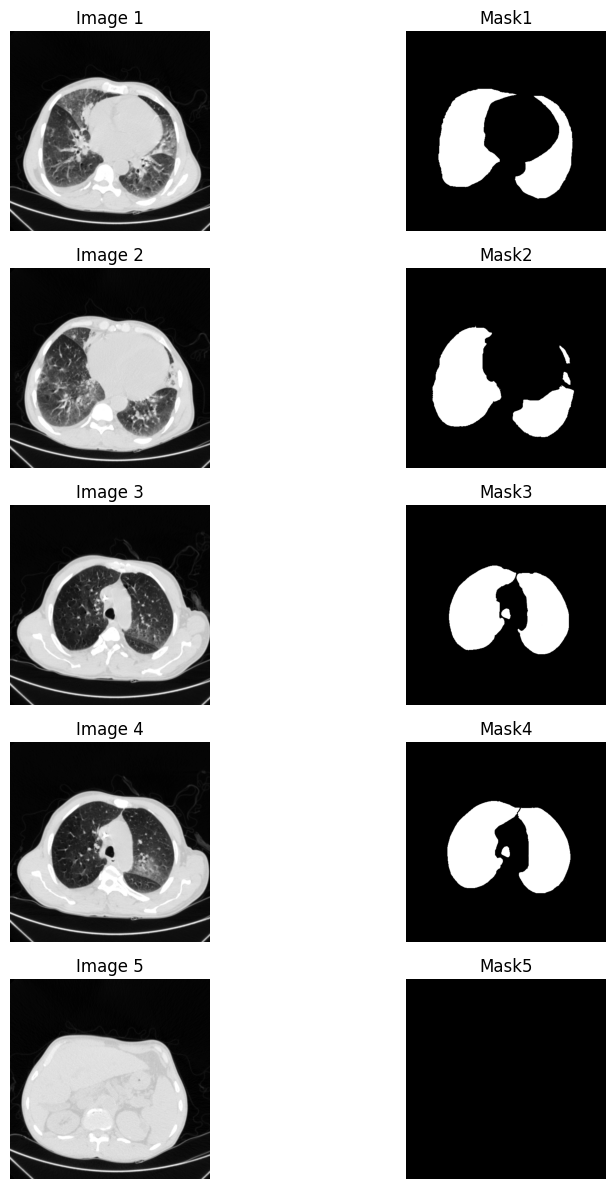

In [ ]:
plt.figure(figsize=(10,12),dpi=100)
for image, mask in zip(lung_train_ds.take(1),mask_train_ds.take(1)): ## take one batch
    for i in range(5): ## plot 5 images with their corresponding masks...
        plt.subplot(5,2,i*2+1)
        plt.imshow(image[i],cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
        plt.subplot(5,2,i*2+2)
        plt.imshow(mask[i],cmap='gray')
        plt.title(f"Mask{i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

## `i` Model Design

In [ ]:
## Design parts of U_net....

### Encoder Block..
def double_conv(input,n_filters,filter_dim=(3,3),activation='relu'):
    x = Conv2D(n_filters,filter_dim,activation=activation,padding='same',kernel_initializer='he_normal')(input)
    x = Conv2D(n_filters,filter_dim,activation=activation,padding='same',kernel_initializer='he_normal')(x)

    return x


In [ ]:
## bottel_neck Block

def downsampling(x,n_filters):
    f_map = double_conv(x,n_filters)
    pool = MaxPooling2D()(f_map)

    return f_map,pool


In [ ]:
## Upsampling Block
def upsampling(x,n_filters,skip_features):
    x = Conv2DTranspose(n_filters,(3,3),strides=2,padding='same')(x)
    x = Concatenate()([x,skip_features])
    x = double_conv(x,n_filters)
    return x

In [ ]:
### Preprocess dataset (Applying Augmentation inside the model....)
##Use 32 → 64 → 128 → 256 → 512 → 256 → 128 → 64 → 32 architecture.

input = Input((512,512,1))
## scale the input
scaled_input = Rescaling(1./255)(input)

## downsampling
f1,p1 = downsampling(scaled_input,32)
f2,p2 = downsampling(p1,64)
f3,p3 = downsampling(p2,128)
f4,p4 = downsampling(p3,256)

## bottelneck
b_neck = double_conv(p4,512)

## Upsampling..
up4 = upsampling(b_neck,256,f4)
up3 = upsampling(up4,128,f3)
up2 = upsampling(up3,64,f2)
up1 = upsampling(up2,32,f1)

## Output
output = Conv2D(1,(1,1),activation='sigmoid')(up1)

model = Model(input,output,name='U_net')
model.summary()

Model: "U_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 512, 512,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 512, 512,  │        320 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 512, 512,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 256, 256,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 128, 128,  │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 64, 64,    │  1,179,904 │ conv2d_9[0][0]  

 Total params: 8,629,921 (32.92 MB)

 Trainable params: 8,629,921 (32.92 MB)

 Non-trainable params: 0 (0.00 B)

## `ii` Model Compilation & Training

In [ ]:
### make x,y in zip dataset...
train = tf.data.Dataset.zip(lung_train_ds,mask_train_ds.map(lambda x:Rescaling(1./255)(x)))
val = tf.data.Dataset.zip(lung_val_ds,mask_val_ds.map(lambda x:Rescaling(1./255)(x)))

In [ ]:
### compile the model
model.compile(keras.optimizers.Adam(),loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(x=train,epochs=EPOCHS,validation_data=val,
                   steps_per_epoch=lung_train_ds.cardinality().numpy(),
                   validation_steps=lung_val_ds.cardinality().numpy()
                   )

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8834 - loss: 2.3485 - val_accuracy: 0.8835 - val_loss: 0.4116
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 620ms/step - accuracy: 0.8933 - loss: 0.3894 - val_accuracy: 0.8835 - val_loss: 0.3989
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 618ms/step - accuracy: 0.8927 - loss: 0.3677 - val_accuracy: 0.8835 - val_loss: 0.2736
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 624ms/step - accuracy: 0.8947 - loss: 0.2682 - val_accuracy: 0.8835 - val_loss: 0.3442
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 634ms/step - accuracy: 0.8937 - loss: 0.2365 - val_accuracy: 0.8835 - val_loss: 0.2199
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 627ms/step - accuracy: 0.8874 - loss: 0.2151 - val_accuracy: 0.8835 - val_loss: 0.2225
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 616ms/step - accuracy: 0.8908 - loss: 0.2155 - val_accuracy: 0.8835 - val_loss: 0.2158
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 622ms/step - accuracy: 0.8903 - loss: 0.2132 - val_accurac

## `iii` Model Evaluation

In [ ]:
train_loss, train_acc = model.evaluate(train)
test_loss, test_acc = model.evaluate(val)

print(f"Accuracy for training: {train_acc * 100:.2f}")
print(f"Accuracy for testing: {test_acc * 100:.2f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.9900 - loss: 0.0270
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - accuracy: 0.9889 - loss: 0.0303
Accuracy for training: 98.99
Accuracy for testing: 98.97


## `iv` Result Visualization

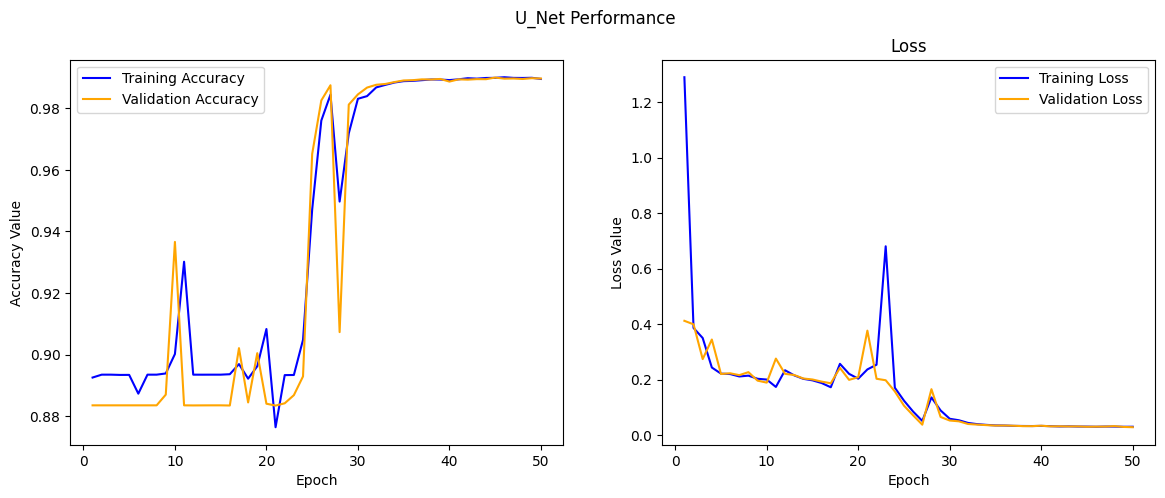

In [ ]:
# Plot the training accuracy and loss

Acc = history.history['accuracy']
Val_Acc =history.history['val_accuracy']
Loss = history.history['loss']
Val_Loss = history.history['val_loss']
epochs = range(1, len(Acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax[0].plot(epochs, Acc, label='Training Accuracy', color='blue')
ax[0].plot(epochs, Val_Acc, label='Validation Accuracy', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()

fig.suptitle('U_Net Performance')
# Plot Loss
ax[1].plot(epochs,Loss, label='Training Loss', color='blue')
ax[1].plot(epochs, Val_Loss, label='Validation Loss', color='orange')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

plt.show();

## `v` It's Time for Segmentation!!

Let's try to predict the mask of some validation samples and plot the results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step


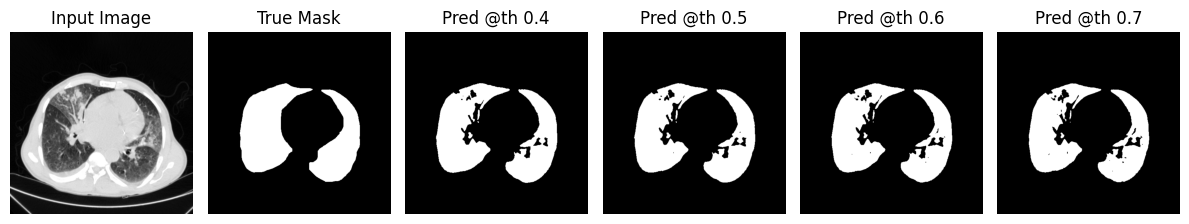

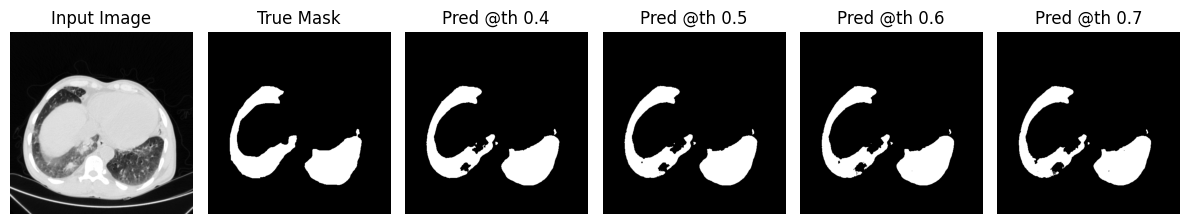

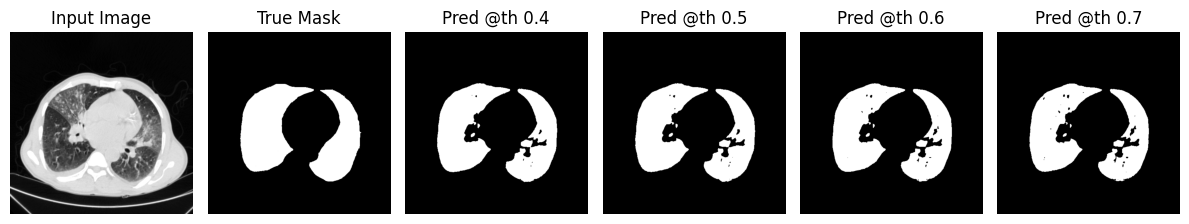

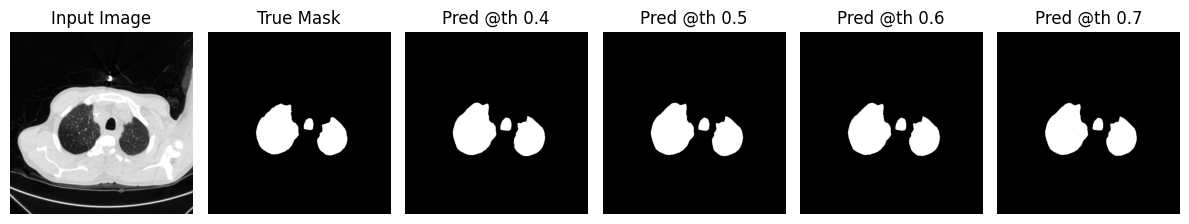

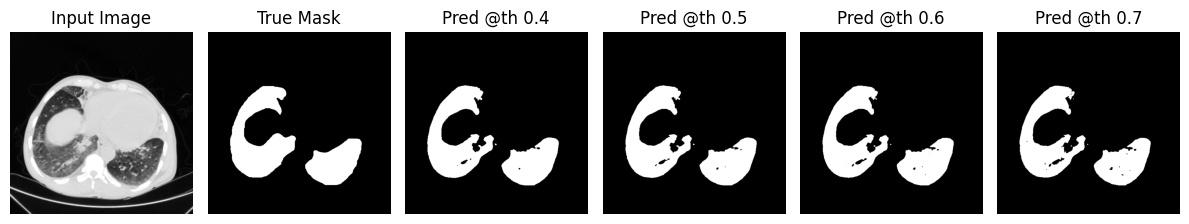

In [ ]:
def plot_predictions(num_images=5, threshold_values=[0.4, 0.5, 0.6, 0.7]):
    for image_batch, mask_batch in val.take(1):
        predictions = model.predict(image_batch)

        for i in range(num_images):
            fig, axes = plt.subplots(1, 2 + len(threshold_values), figsize=(2 * (2 + len(threshold_values)), 4))

            # Original Image
            axes[0].imshow(image_batch[i, :, :, 0], cmap='gray')
            axes[0].set_title("Input Image")
            axes[0].axis('off')

            # True Mask
            axes[1].imshow(mask_batch[i, :, :, 0], cmap='gray')
            axes[1].set_title("True Mask")
            axes[1].axis('off')

            # Predicted masks for each threshold
            for j, threshold in enumerate(threshold_values):
                pred_mask = (predictions[i, :, :, 0] > threshold).astype(int)
                axes[j + 2].imshow(pred_mask, cmap='gray')
                axes[j + 2].set_title(f"Pred @th {threshold}")
                axes[j + 2].axis('off')

            plt.tight_layout()
            plt.show()

plot_predictions()

**Note:** You can add more trials and explore different hyperparameters and design decisions as you want.

------------------------------

# Assignment 02
- Design your Deep Convolutional Neural Network using `Transfer Learning`
- You can select any pretrained model as a base and build on top.
- The task is to successfully classify images of cats and dogs using the dataset [here](https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip).
- There are no constraint; you have **full power**.




## `+` Set Global Parameters

In [5]:
# Hyperparameters
BATCH_SIZE  = 64
EPOCHS      = 15

## `+` Downlaod, Load & Preprocess Cats & Dogs Data

### Download & Extract the Dataset

In [6]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   224M      0  0:00:03  0:00:03 --:--:--  224M


In [7]:
!unzip -q kagglecatsanddogs_5340.zip
!ls -Rd PetImages/*

PetImages/Cat  PetImages/Dog


In [8]:
# Delete Corrupted Images

num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 1590 images.


### Load & Preprocess the Dataset

**Reminder:** You might need rescaling, data augmentation, and/or other preprocessing methods.

In [9]:
# Training/Validation Dataset
train_ds, val_ds = image_dataset_from_directory('PetImages',
                                                batch_size=BATCH_SIZE,
                                                seed=SEED,
                                                label_mode='binary',
                                                image_size=(180,180),
                                                validation_split=0.2,
                                                subset="both")

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Using 4682 files for validation.


### Preview the Images

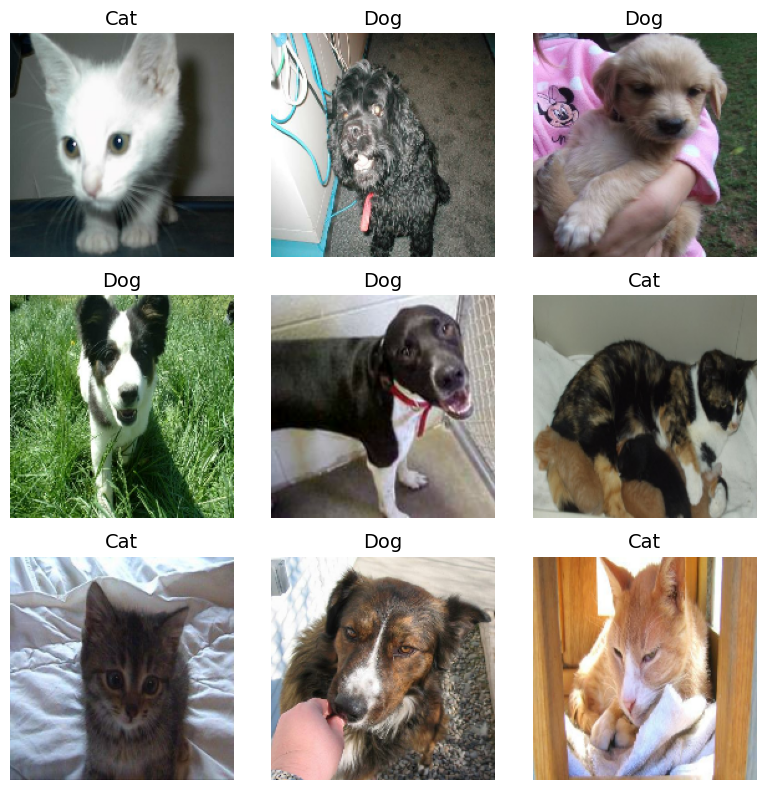

In [12]:
def plot_batch_images():
    plt.figure(figsize=(8, 8))

    count = 0
    for images, labels in train_ds.take(1):
        for i in range(min(9, images.shape[0])):
            count += 1
            plt.subplot(3, 3, count)
            plt.imshow(np.array(images[i]).astype('uint8'))
            # Convert labels[i] to a NumPy array and then to an integer
            plt.title(f'{["Cat", "Dog"][int(labels[i].numpy())]}', fontsize=14)
            plt.axis('off')

    plt.tight_layout()
    plt.show()
plot_batch_images()

----------------------------------
## `i` Model Design

###  Adding Augmentation to the Model

In [13]:
# Apply preprocess_input to each image in the dataset
train_ds = train_ds.map(lambda image, label: (preprocess_input(image), label))
val_ds = val_ds.map(lambda image, label: (preprocess_input(image), label))

Great question! This touches on a subtle but **important difference** in how models behave during inference and training in TensorFlow/Keras. Let's break it down clearly:

---

### 🔹 `x = base_model(inputs, training=False)`

This means:

* You are **manually telling** the model to behave in **inference mode**, regardless of whether you're training or not.
* This impacts:

  * **Dropout** → turned **off**.
  * **Batch Normalization** → uses **moving averages** instead of batch statistics.
* But this does **not affect** whether the model’s weights can be updated — it can still be trainable or not.

📌 **Use case**: You want to keep the model behavior consistent (like during inference) but might still allow weight updates (if trainable).

---

### 🔹 `base_model.trainable = False`

This means:

* You are **freezing all the layers** of `base_model`. Their weights will **not be updated** during training.
* But during forward passes:

  * If `training=True`, things like dropout and batch norm still behave as if you're training.
  * So this affects **trainability**, not behavior.

📌 **Use case**: You want to freeze the weights of a pretrained model during fine-tuning.

---

### ✅ So, the difference in one sentence:

* `training=False` → affects **layer behavior (like dropout/batchnorm)** during the forward pass.
* `model.trainable = False` → affects **whether the model’s weights can be updated** during backpropagation.

---

### 🔁 Use Them Together?

Often, yes — for example, in transfer learning:

```python
base_model.trainable = False  # freeze weights
x = base_model(inputs, training=False)  # inference behavior (no dropout, etc.)
```

This ensures:

* You're **not training** the base model weights.
* You're also **not applying training-specific behaviors** like dropout and batch norm batch-wise updates.

---

Let me know if you want a code example or experiment idea to see the difference in action.


In [14]:
# Input Layer
inputs = Input(shape=(180, 180, 3))

# Augmentation Layer
x = RandomFlip()(inputs)
x = RandomRotation(0.2)(x)

# Pretrained Base Model
base_model = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=x)
base_model.trainable = False

# Extract Features
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Fully Connected Layers
x = Dense(128)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output Layer
outputs = Dense(1, activation='sigmoid')(x)

# Final Model
pre_model = Model(inputs, outputs,name="PreTrained_Model")

# Summary
pre_model.summary()


219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "PreTrained_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip         │ (None, 180, 180,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation     │ (None, 180, 180,  │          0 │ random_flip[0][0] │
│ (RandomRotation)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 89, 89,    │        864 │ random_rotation[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 89, 89,    │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 89, 89,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 87, 87,    │      9,216 │ activation[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 87, 87,    │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 87, 87,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 87, 87,    │     18,432 │ activation_1[0][… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 87, 87,    │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 87, 87,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 43, 43,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 43, 43,    │      5,120 │ max_pooling2d[0]… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 43, 43,    │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 43, 43,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 41, 41,    │    138,240 │ activation_3[0][

 Total params: 54,534,113 (208.03 MB)

 Trainable params: 197,121 (770.00 KB)

 Non-trainable params: 54,336,992 (207.28 MB)

## `ii` Model Compilation & Training

In [15]:
# Compile
pre_model.compile(keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
hist = pre_model.fit(train_ds,epochs=EPOCHS,validation_data=val_ds)

Epoch 1/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 117s 314ms/step - accuracy: 0.9138 - loss: 0.2056 - val_accuracy: 0.9821 - val_loss: 0.0513
Epoch 2/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 85s 290ms/step - accuracy: 0.9418 - loss: 0.1458 - val_accuracy: 0.9853 - val_loss: 0.0427
Epoch 3/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 90s 308ms/step - accuracy: 0.9446 - loss: 0.1396 - val_accuracy: 0.9880 - val_loss: 0.0363
Epoch 4/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 87s 298ms/step - accuracy: 0.9459 - loss: 0.1343 - val_accuracy: 0.9848 - val_loss: 0.0372
Epoch 5/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 140s 290ms/step - accuracy: 0.9485 - loss: 0.1280 - val_accuracy: 0.9876 - val_loss: 0.0369
Epoch 6/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 87s 297ms/step - accuracy: 0.9491 - loss: 0.1277 - val_accuracy: 0.9870 - val_loss: 0.0373
Epoch 7/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 144s 303ms/step - accuracy: 0.9539 - loss: 0.1170 - val_accuracy: 0.9855 - val_loss: 0.0405
Epoch 8/15
293/293 ━━━━━━━━━━━━━━━━━━━━ 90s 307ms/step - accuracy: 0.9578 - loss

## `iii` Model Evaluation

In [17]:
train_loss, train_acc = pre_model.evaluate(train_ds)
test_loss, test_acc = pre_model.evaluate(val_ds)

print(f"Accuracy for training: {train_acc * 100:.2f}")
print(f"Accuracy for testing: {test_acc * 100:.2f}")

293/293 ━━━━━━━━━━━━━━━━━━━━ 69s 234ms/step - accuracy: 0.9879 - loss: 0.0358
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 235ms/step - accuracy: 0.9834 - loss: 0.0394
Accuracy for training: 98.91
Accuracy for testing: 98.44


## `iv` Result Visualization

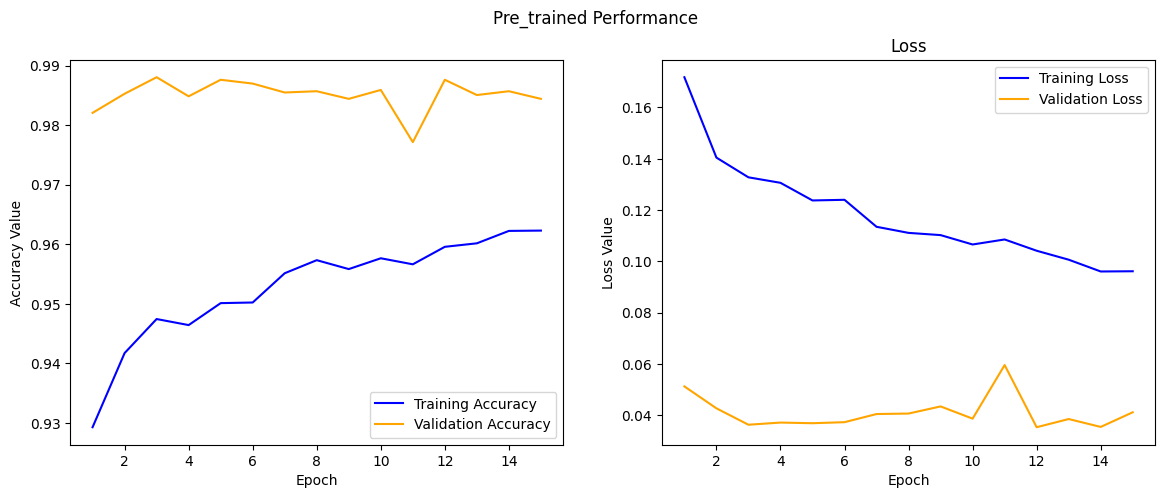

In [18]:
# Plot the training accuracy and loss

Acc = hist.history['accuracy']
Val_Acc =hist.history['val_accuracy']
Loss = hist.history['loss']
Val_Loss = hist.history['val_loss']
epochs = range(1, len(Acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot Accuracy
ax[0].plot(epochs, Acc, label='Training Accuracy', color='blue')
ax[0].plot(epochs, Val_Acc, label='Validation Accuracy', color='orange')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy Value')
ax[0].legend()

fig.suptitle('Pre_trained Performance')
# Plot Loss
ax[1].plot(epochs,Loss, label='Training Loss', color='blue')
ax[1].plot(epochs, Val_Loss, label='Validation Loss', color='orange')
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss Value')
ax[1].legend()

plt.show();

## `v` Let's Test Our Model

Let's try to predict the class of some validation samples and plot the results.

Also, try to classify an image from the internet.

**Note:** remember to properly process the image (dimensions, rescaling, etc.)

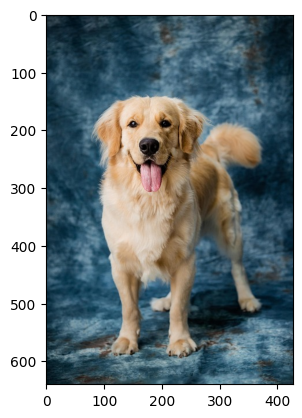

In [ ]:
img = mpimg.imread('/content/test.jpg')
imgplot = plt.imshow(img)
plt.show()

In [20]:
img = Lambda(lambda x: tf.cast(x, tf.float32))(img)
img = Lambda(preprocess_input)(img)
img = tf.image.resize(img, [180, 180])
img = np.expand_dims(img, axis=0)

In [21]:
prediction=pre_model.predict([img])

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [22]:
true_label='Dog'
class_names = ['Cat', 'Dog']

if prediction[0] < 0.5:
    predicted_label = class_names[0]  # 'Cat'
else:
    predicted_label = class_names[1]  # 'Dog'

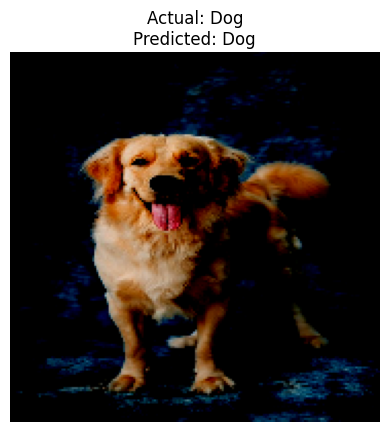

In [23]:
# Plot the Input, True Label, and Predicted Label
plt.imshow(img[0])
plt.title(f"Actual: {true_label}\nPredicted: {predicted_label}")
plt.axis('off')
plt.show();

In [24]:
for images, labels in val_ds.take(1):
    preds = pre_model.predict(images)
    for i in range(5):
        print(f"Pred: {preds[i][0]:.4f}, True label: {labels[i].numpy()}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step
Pred: 0.2689, True label: [0.]
Pred: 0.9925, True label: [1.]
Pred: 0.5727, True label: [1.]
Pred: 0.9999, True label: [1.]
Pred: 0.0292, True label: [0.]


----------------------------------------------

$$ Wish \space you \space all \space the \space best \space ♡ $$
$$ Abdelrahman \space Eid $$